## Options and Libraries

In [1]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

# set theme for plots
sns.set_theme()

## Read data

In [3]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb


# one hot
df_full_dummies = pd.get_dummies(df, drop_first=True)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies = df_full_dummies.drop(columns=[
    "response",
    "income_pred",
    "year_birth",
    "income_error", 
    "income_error_relative"
])

df_sel_dummies = df_full_dummies.drop(columns=[
    "id",
    
    #"marital_status_Divorced",
    "marital_status_Married",
    "marital_status_Single",
    "marital_status_Together",
    "marital_status_Widow",

    #"education_Basic",
    "education_2n Cycle",
    "education_Graduation",
    "education_Master",
    "education_PhD",

    #"mnt_wines",
    #"mnt_fruits",
    #"mnt_meat",
    #"mnt_fish",
    #"mnt_sweet",
    #"mnt_gold",
    
    #"num_deals",
    #"num_web",
    #"num_catalog",
    #"num_store",
    #"num_web_visits_month",
    
    "accepted_cmp1",
    "accepted_cmp2",
    "accepted_cmp3",
    "accepted_cmp4",
    "accepted_cmp5",
    "accepted_any",
    #"accepted_total",

    "dt_customer",
    #"recency",
    "complain",
    ],
    inplace=False)

In [4]:
# dropping some columns for "more targeted model"
regex_drop = r"error"
drop_cols = df_sel_dummies.filter(regex=regex_drop).columns

print(drop_cols)
df_sel_dummies.drop(columns=drop_cols, inplace=True)

Index([], dtype='object')


In [5]:
def visualize_selected_features(df, features, target_var=None, nrows=5, ncols=5, figsize=(20, 20)):
    """
    Visualizes selected features of a DataFrame grouped by a target variable.
    
    Parameters:
    - df (pd.DataFrame): The input dataset.
    - features (list): A list of feature names to visualize.
    - target_var (str): The column name of the target variable
    - nrows (int): Number of rows in the subplot grid. Default is 5.
    - ncols (int): Number of columns in the subplot grid. Default is 5.
    - figsize (tuple): Size of the overall figure. Default is (20, 20).
    """
    # Define the figure and axes for the grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
       
    # Loop over each feature and plot based on its type
    for i, feature in enumerate(features):
        if i >= len(axes):  # Skip plotting if axes are exhausted
            break
        
        if df[feature].dtype in ["float64", "int64"] and df[feature].max() > 0:  # Numerical features
            sns.histplot(data=df, x=feature, hue=target_var, kde=True, ax=axes[i])

        elif df[feature].dtype in ["category", "object"]:  # Nominal features
            sns.countplot(data=df, x=feature, hue=target_var, ax=axes[i])

        else:  # Ordinal or other types
            sns.violinplot(data=df, x=target_var, y=feature, ax=axes[i])
        
        # Set the title for the plot
        axes[i].set_title(feature)
        # axes[i].set_yscale("log")  
        axes[i].set(xlabel=None, ylabel=None)
    
    # Hide any remaining unused axes in the grid
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    

    plt.tight_layout()
    plt.show()

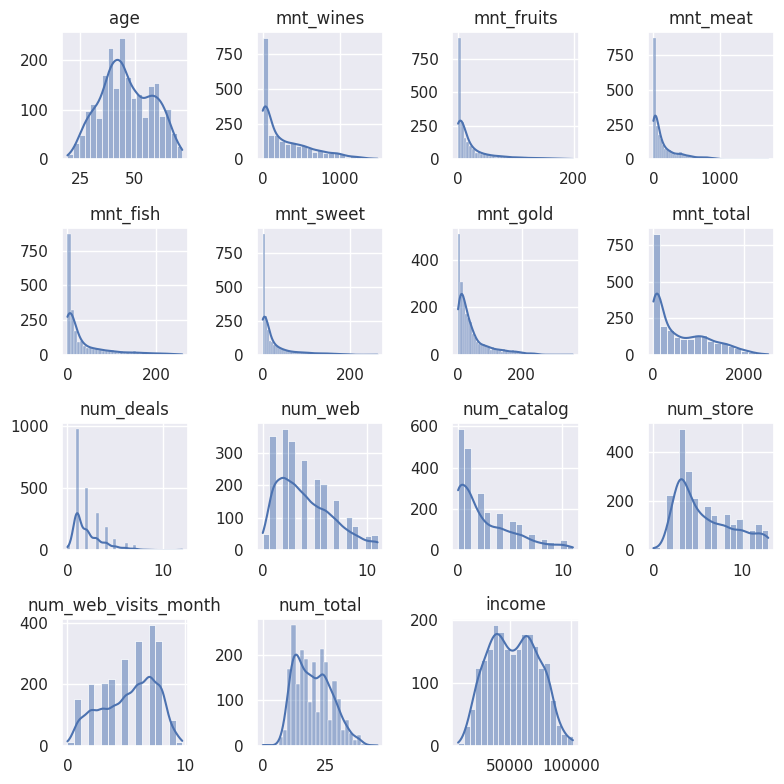

In [6]:
num_features = [
    "age",
    
    "mnt_wines",
    "mnt_fruits",
    "mnt_meat",
    "mnt_fish",
    "mnt_sweet",
    "mnt_gold",
    "mnt_total",
    "num_deals", 
    "num_web", 
    "num_catalog", 
    "num_store", 
    "num_web_visits_month",
    "num_total", 
    "income", 
]

# Call the function for specific features
visualize_selected_features(
    df=df_full_dummies,
    features=num_features,
    nrows=4, 
    ncols=4, 
    figsize=(8,8)
)

## Evaluate Clustering Algorithms

In [7]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

def evaluate_clustering(model_class, X, k_range, **model_kwargs):
    """
    Evaluates clustering models for a range of cluster numbers.
    """
    results = []
    
    for k in k_range:
        # Instantiate the clustering model with the current number of clusters
        model = model_class(k, **model_kwargs) 
        
        # Fit the model and predict labels
        model.fit(X)
        labels = model.labels_ if hasattr(model, "labels_") else model.predict(X)
        
        # Compute clustering statistics
        stats = {
            "k": k,
            "silhouette_score ↑": silhouette_score(X, labels),
            "calinski_harabasz_score ↑": calinski_harabasz_score(X, labels),
            "davies_bouldin_score ↓": davies_bouldin_score(X, labels),
        }
        results.append(stats)
    
    # Convert results into a DataFrame
    return pd.DataFrame(results).style.hide()


In [8]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df_sel_dummies)
df_scaled = pd.DataFrame(df_scaled, columns = df_sel_dummies.columns)
df_scaled.head(6)

,age,education_years,income,kidhome,teenhome,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total,marital_status_simple_Single
0,1.012620,-0.350051,0.267877,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,1.679417,0.366793,1.491860,2.665261,-0.550785,0.740812,1.621229,-0.439037,1.346874
1,1.268542,-0.350051,-0.328028,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.961275,-0.168114,-1.157932,-0.591401,-1.166125,-0.123617,-1.258779,-0.439037,1.346874
2,0.330160,-0.350051,0.948717,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,0.282673,-0.703020,1.491860,-0.229549,1.295237,-0.555832,0.661226,-0.439037,-0.742460
3,-1.290681,-0.350051,-1.323292,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.918094,-0.168114,-0.779390,-0.953252,-0.550785,0.308597,-0.847349,-0.439037,-0.742460
4,-1.034759,1.557769,0.275709,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,-0.305254,1.436606,0.356235,0.132302,0.064556,-0.123617,0.524083,-0.439037,-0.742460
5,0.159545,0.285889,0.488929,-0.825218,0.906934,-1.143438,0.642051,0.394768,-0.305541,-0.687068,0.361924,-0.575619,0.183025,-0.168114,0.734776,0.494153,1.295237,0.308597,1.072656,-0.439037,-0.742460


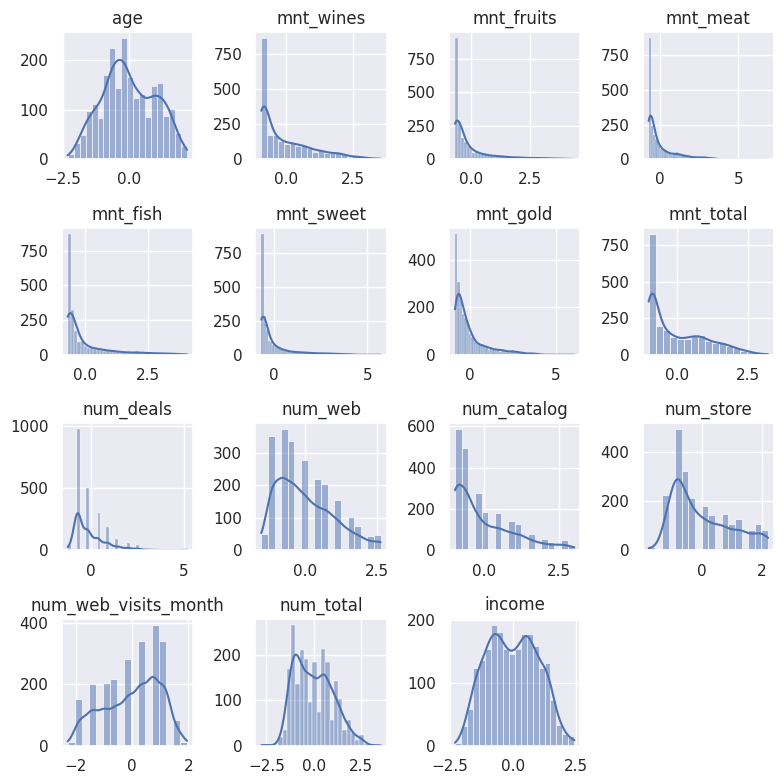

In [9]:
num_features = [
    "age",
    
    "mnt_wines",
    "mnt_fruits",
    "mnt_meat",
    "mnt_fish",
    "mnt_sweet",
    "mnt_gold",
    "mnt_total",
    "num_deals", 
    "num_web", 
    "num_catalog", 
    "num_store", 
    "num_web_visits_month",
    "num_total", 
    "income", 
]

# Call the function for specific features
visualize_selected_features(
    df=df_scaled,
    features=num_features,
    nrows=4, 
    ncols=4, 
    figsize=(8,8)
)

### K-Means

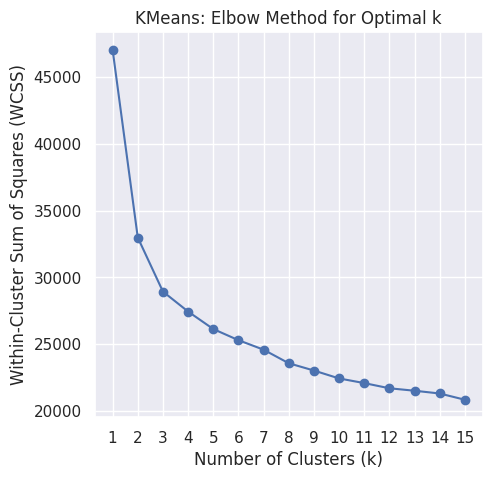

In [22]:
from sklearn.cluster import KMeans

# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 15+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", max_iter=1000)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)



plt.savefig(
    "output/figures/fig_kmeans_elbow_method.png",
    dpi=300,
    bbox_inches='tight'
)

WCSS: measures the sum of squared distances between each data point and the centroid of its assigned cluster. 

In [23]:
# Evaluate KMeans
from sklearn.cluster import KMeans

kmeans_stats = evaluate_clustering(KMeans, df_scaled, range(2, 15), random_state=42, init="k-means++", max_iter=111)
print("KMeans Results:")
kmeans_stats

KMeans Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.286372,953.377971,1.489415
3,0.222618,699.410382,1.822381
4,0.130542,532.048516,2.099176
5,0.126684,446.781956,2.275537
6,0.118125,383.746310,2.232688
7,0.112043,339.681532,2.360505
8,0.114078,317.251275,2.301860
9,0.112406,290.665185,2.288174
10,0.113152,271.598916,2.283039
11,0.110135,251.682422,2.308911


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


### Gaussian Mixture

In [12]:
# Evaluate Gaussian Mixture
from sklearn.mixture import GaussianMixture

gmm_stats = evaluate_clustering(GaussianMixture, df_scaled, range(2, 7), random_state=42)
print("Gaussian Mixture Results:")
gmm_stats


Gaussian Mixture Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.261797,860.086035,1.557157
3,0.183039,597.449758,2.157730
4,0.106480,332.602208,3.131868
5,0.089654,277.399072,3.745267
6,0.081572,282.448770,3.204650


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


#### Results of comparison 

- Not unambiguous when comparing across and within algorithms:
  - gaussian mixture has better silhouette, worse Calinski-Harabasz-Score and similar Davies-Bouldin-Score

## PCA

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit_transform(df_scaled)

exp_var_pca_sng = pca.explained_variance_ratio_
print(exp_var_pca_sng)
exp_var_pca_sum = np.cumsum(pca.explained_variance_ratio_)
print(exp_var_pca_sum)


[0.3745782  0.11609429 0.07033617 0.05751845 0.04789004 0.04759616 0.04160805 0.03292701 0.03057651 0.02950232]
[0.3745782  0.4906725  0.56100866 0.61852712 0.66641716 0.71401332 0.75562137 0.78854838 0.81912489 0.84862721]


In [42]:
_pca_1 = df_scaled.dot(pca.components_[0])
_pca_2 = df_scaled.dot(pca.components_[1])
_pca_3 = df_scaled.dot(pca.components_[2])
_pca_4 = df_scaled.dot(pca.components_[3])
_pca_5 = df_scaled.dot(pca.components_[4])

df2 = pd.DataFrame({
    "_pca_1" : _pca_1,
    "_pca_2" : _pca_2,
    "_pca_3" : _pca_3,
    "_pca_4" : _pca_4,
    "_pca_5" : _pca_5
    })

df2

,_pca_1,_pca_2,_pca_3,_pca_4,_pca_5
0,4.367991,0.141548,-1.549696,-0.803044,1.206013
1,-2.799807,-0.280892,1.309312,-0.881888,0.579360
2,1.937846,-0.150758,-0.236356,-0.532729,-1.298002
3,-2.972394,-1.037722,-0.983209,0.604720,-1.051901
4,-0.190669,0.586141,-0.725691,0.560237,0.708856
...,...,...,...,...,...
2235,2.887402,0.884752,-1.071772,-1.290804,-0.436890
2236,-0.725653,3.940356,0.562717,1.261734,-0.048851
2237,1.853951,-0.596946,-0.313729,1.556994,1.943536
2238,2.203447,0.889914,1.066912,-1.018858,-1.696254


In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, init="k-means++", max_iter=1000)
kmeans.fit(df2)

_pred = kmeans.predict(df2)
df2["pred_cluster"] = _pred


In [45]:
def reorder_clusters(df, cluster_col='pred_cluster', order_by='income'):
    dfc = df.copy()
    # Calculate the average income for each cluster
    cluster_avg_income = dfc.groupby(cluster_col)[order_by].mean().sort_values(ascending=False)
    cluster_avg_income = pd.to_numeric(cluster_avg_income)
    
    # Create a mapping of cluster labels to new labels
    new_cluster_labels = {old_label: f'{i+1}' for i, old_label in enumerate(cluster_avg_income.index)}
    
    # Re-map the cluster column
    dfc['pred_cluster'] = pd.to_numeric(dfc[cluster_col].map(new_cluster_labels))
    
    # Rename the probability columns based on the new cluster order
    for old_label, new_label in new_cluster_labels.items():
        prob_col_name = f'prob_cluster_{old_label}'
        if prob_col_name in dfc.columns:
            
            # Rename the column
            dfc.rename(columns={prob_col_name: f'_prob_{new_label}'}, inplace=True)
            #dfc.drop(columns="pred_cluster", axis=1, inplace=True)
    
    # Reorder the columns to have a nice order
    cols = []  # Start with the reordered cluster column
    cluster_cols = [col for col in dfc.columns if '_prob_' in col]  # All probability columns
    cluster_cols = sorted(cluster_cols)
    other_cols = [col for col in dfc.columns if col not in cols + cluster_cols]  # All other columns
    dfc = dfc[cols + other_cols + cluster_cols ]

    return dfc


In [46]:
x_winner = df2

# Append to existing DataFrame
df2_clustered = pd.concat(
    [df_full_dummies.reset_index(drop=True),
    x_winner.reset_index(drop=True)], axis=1, ignore_index=False)

# reorder the cluster by: 
order_by = "income" # mnt_total is also a good one
order_by = "mnt_total" # mnt_total is also a good one
df2_clustered = reorder_clusters(df2_clustered, order_by=order_by)

df2_clustered.groupby("pred_cluster").mean()

,id,age,education_years,income,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_cmp1,accepted_cmp2,accepted_cmp3,accepted_cmp4,accepted_cmp5,complain,accepted_total,accepted_any,education_2n Cycle,education_Graduation,education_Master,education_PhD,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow,marital_status_simple_Single,_pca_1,_pca_2,_pca_3,_pca_4,_pca_5
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5706.151618,46.580298,17.086882,75946.789615,0.037479,0.175468,15894.127768,49.655877,614.306644,67.601363,449.890971,98.040886,70.528109,78.383305,1378.751278,1.212947,5.146508,5.831346,8.407155,2.812606,23.528109,0.211244,0.034072,0.083475,0.136286,0.262351,0.005111,0.727428,0.424191,0.095400,0.562181,0.146508,0.195911,0.362862,0.241908,0.255537,0.044293,0.381601,3.640946,-1.094084,0.001841,0.058202,0.006050
2,5492.040717,50.201319,17.920195,57305.968578,0.281759,0.925081,15839.283388,48.166124,452.376221,22.527687,139.975570,30.047231,22.229642,59.600977,726.757329,4.008143,6.372964,3.087948,7.587948,5.944984,27.171010,0.030945,0.013029,0.068404,0.120521,0.014658,0.009772,0.247557,0.210098,0.050489,0.467427,0.187296,0.293160,0.400651,0.169381,0.267101,0.039088,0.332248,0.825631,1.861440,-0.022022,-0.114740,-0.041549
3,5586.923965,43.469119,16.624639,37138.172605,0.769971,0.445621,15931.475457,49.358037,40.865255,5.200192,23.038499,7.755534,5.362849,15.402310,97.624639,1.935515,2.076997,0.560154,3.249278,6.293975,14.153994,0.000962,0.001925,0.069297,0.012512,0.000000,0.011550,0.084697,0.081809,0.111646,0.490857,0.162656,0.183831,0.389798,0.231954,0.256015,0.025987,0.354187,-2.544921,-0.481903,0.011974,0.034924,0.021135


In [47]:
kmeans_stats = evaluate_clustering(KMeans, df2, range(2, 15), random_state=42, init="k-means++", max_iter=111)
kmeans_stats


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.405071,1912.548513,1.030867
3,0.356655,1639.799486,1.169098
4,0.266569,1238.853661,1.486918
5,0.224588,1092.530932,1.577395
6,0.219524,1016.231506,1.602226
7,0.204537,899.894375,1.636083
8,0.211096,852.863244,1.554096
9,0.187824,798.799833,1.551344
10,0.190688,735.171688,1.576126
11,0.179709,696.167853,1.538349


In [50]:
# Evaluate Gaussian Mixture
from sklearn.mixture import GaussianMixture

gmm_stats = evaluate_clustering(GaussianMixture, df2, range(2, 7), random_state=42)
print("Gaussian Mixture Results:")
gmm_stats

Gaussian Mixture Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.378358,1709.217498,1.043269
3,0.356655,1639.799486,1.169098
4,0.240681,1171.325877,1.682920
5,0.211117,1052.343713,1.712009
6,0.200965,970.038946,1.776305


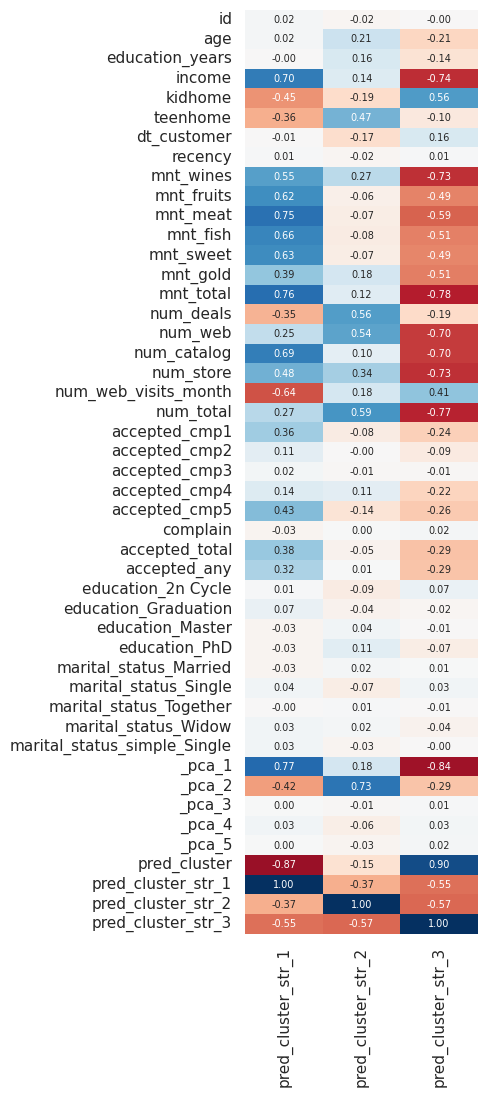

In [49]:
# get correlations 
df2_clustered["pred_cluster_str"] = df2_clustered["pred_cluster"].astype(str)
df2_clustered_to_plot = pd.get_dummies(df2_clustered, drop_first=False)
df2_clustered_to_plot = df2_clustered_to_plot.corr()
# remove from bottom
df2_clustered_to_plot = df2_clustered_to_plot.filter(regex="r_str", axis=1)
# remove from left
# df2_clustered_to_plot.drop(["pred_cluster"], axis=0, inplace=True)

from matplotlib import pyplot as plt
import seaborn as sns

def heatmap(df, file_name=None, figsize=(10,5)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df,
        cmap='RdBu',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 7},
        vmin=-1, vmax=1,
        cbar=False
    )

    if file_name is not None:
        # save the plot as JPG file
        #print(f"saving {file_name}")
        plt.savefig(
            file_name,
            dpi=300,
            bbox_inches='tight'
        )
        #plt.xticks(rotation=0)
        plt.show()


heatmap(df2_clustered_to_plot,
    file_name=f"output/figures/fig_corrplot_first_look_123_clst_income_pred2222.png",
    figsize=(3,12)
)

In [26]:
# plot opts
sns.set_theme()
p_pal = sns.color_palette("viridis", as_cmap=True)
p_alpha = 1/2

In [30]:
df2_clustered.columns

Index(['id', 'age', 'education_years', 'income', 'kidhome', 'teenhome', 'dt_customer', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold', 'mnt_total', 'num_deals', 'num_web',
       'num_catalog', 'num_store', 'num_web_visits_month', 'num_total', 'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'complain', 'accepted_total', 'accepted_any',
       'education_2n Cycle', 'education_Graduation', 'education_Master', 'education_PhD', 'marital_status_Married', 'marital_status_Single', 'marital_status_Together', 'marital_status_Widow',
       'marital_status_simple_Single', '_pca_1', '_pca_2', 'pred_cluster', 'pred_cluster_str'],
      dtype='object')

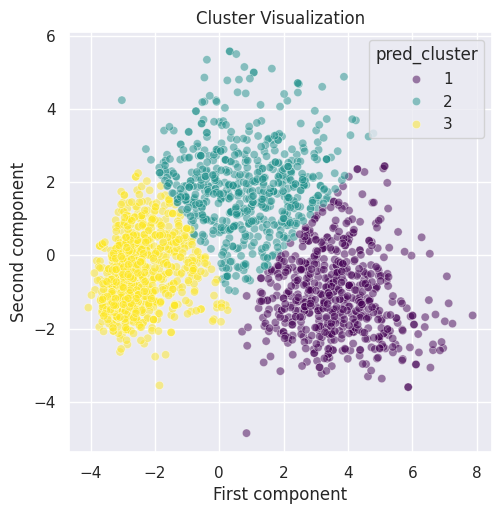

In [34]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df2_clustered, x="_pca_1", y="_pca_2", hue="pred_cluster", alpha=1/2, palette=p_pal)
plt.title("Cluster Visualization")
plt.xlabel("First component")
plt.ylabel("Second component")

plt.savefig(
    "output/figures/fig_df2_scatter_pca1_pca2.png",
    dpi=300,
    bbox_inches='tight'
)

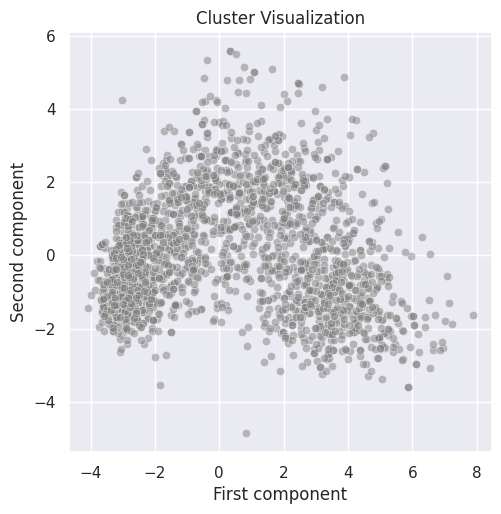

In [33]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df2_clustered, x="_pca_1", y="_pca_2", c="grey", alpha=1/2, palette=p_pal)
plt.title("Cluster Visualization")
plt.xlabel("First component")
plt.ylabel("Second component")

plt.savefig(
    "output/figures/fig_df2_scatter_pca1_pca2_NO_COLOR.png",
    dpi=300,
    bbox_inches='tight'
)

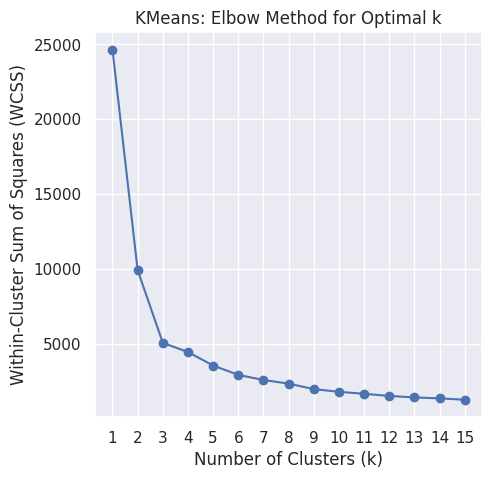

In [35]:
from sklearn.cluster import KMeans

# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 15+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", max_iter=1000)
    kmeans.fit(df2)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)



plt.savefig(
    "output/figures/fig_df2_kmeans_elbow_method.png",
    dpi=300,
    bbox_inches='tight'
)

In [36]:
df2

,_pca_1,_pca_2,pred_cluster
0,4.367991,0.141548,1
1,-2.799807,-0.280892,0
2,1.937846,-0.150758,1
3,-2.972394,-1.037722,0
4,-0.190669,0.586141,2
...,...,...,...
2235,2.887402,0.884752,1
2236,-0.725653,3.940356,2
2237,1.853951,-0.596946,1
2238,2.203447,0.889914,2
